<a href="https://colab.research.google.com/github/LCaravaggio/NLP/blob/main/06_clasificaci%C3%B3n/Entrenar_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

In [3]:
# Vamos a usar datos de reviews de amazon que salen de acá: 
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?select=Reviews.csv

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.shape

(568454, 10)

In [6]:
# Product Scores
fig = px.histogram(df, x="Score")
fig.update_layout(title_text='Product Score')
fig.show()

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

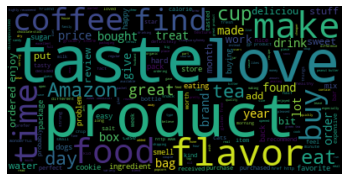

In [10]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

stopwords = set(stopwords.words())
stopwords.update(["br"])

textt = " ".join(review for review in df.Text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda rating : +1 if rating > 3 else -1)

In [12]:
# Genero dos datasets distintos, uno con reviews "positivas" y otro con reviews "negativas"
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

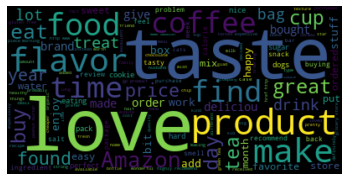

In [13]:
pos = " ".join(review for review in positive.Text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

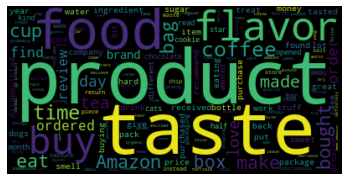

In [14]:
neg = " ".join(review for review in negative.Text)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
df['Text'] = df['Text'].apply(remove_punctuation)
df = df.dropna(subset=['Summary'])
df['Summary'] = df['Summary'].apply(remove_punctuation)

In [16]:
dfNew = df[['Summary','sentiment']]
dfNew.head()

,Summary,sentiment
0,Good Quality Dog Food,1
1,Not as Advertised,-1
2,Delight says it all,1
3,Cough Medicine,-1
4,Great taffy,1


In [17]:
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Summary'])
test_matrix = vectorizer.transform(test['Summary'])

In [19]:
print(train_matrix[0])

  (0, 12226)	1
  (0, 22388)	1
  (0, 8612)	1
  (0, 11132)	1


In [20]:
vectorizer.get_feature_names_out()

array(['0', '00', '000', ..., 'zzzzzzzzz', 'zzzzzzzzzzz', 'åwesome'],
      dtype=object)

In [ ]:
np.where(vectorizer.get_feature_names_out() == 'dog')[0][0]

In [23]:
vectorizer.get_feature_names_out()[8612]

'dog'

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [25]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

In [26]:
lr.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [27]:
predictions = lr.predict(X_test)

In [28]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[11335,  2322],
       [ 5895, 91112]])

In [29]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.66      0.83      0.73     13657
           1       0.98      0.94      0.96     97007

    accuracy                           0.93    110664
   macro avg       0.82      0.88      0.85    110664
weighted avg       0.94      0.93      0.93    110664



In [30]:
print(X_test[0])

  (0, 1062)	1
  (0, 2042)	1
  (0, 19185)	1


In [31]:
lr.predict(X_test[0])

array([-1])

In [32]:
X_test[0]

<1x31640 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [33]:
print(X_test[0])

  (0, 1062)	1
  (0, 2042)	1
  (0, 19185)	1


In [34]:
np.where(vectorizer.get_feature_names_out() == 'horrible')[0][0]

13776

In [42]:
from scipy.sparse import csr_matrix
import numpy as np
data = np.array([1,1])
indices = np.array([6818, 17349])
indptr  = np.array([0,2])
prueba=csr_matrix((data, indices, indptr), shape=(1,31640))

In [37]:
prueba

<1x31635 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [43]:
print(prueba)

  (0, 6818)	1
  (0, 17349)	1


In [44]:
lr.predict(prueba)

array([1])